### Introduction
To start the series of Design Patterns tutorials, I will begin with the Factory pattern since it is popular and easy to grasp. This will help you comprehend the fundamental concepts of Design Patterns. In this lesson, I will present a practical example of using the Factory pattern, and then we will progress by integrating the Abstract Factory into the current example.

### Requirements
Assuming the system's requirements involve the use of two types of caches: Redis and Memcached in the application layer, you can directly call methods within these two types of caches without expressing the object creation logic (It allows you to create objects without specifying the specific class of the object and without needing to know how they are created).

### Analysis
From the aforementioned requirements, it is evident that there is a need to design a shared component for the code mentioned above, which can be utilized without directly impacting the code of these two cache types. Nevertheless, this appears somewhat complex because it is apparent that the cache configuration functions for these two cache types differ, Redis employs redis_set, whereas Memcached utilizes memcached_set. The resolution to this issue entails employing the Factory pattern. The Factory pattern includes a Base class for client classes to inherit, thus necessitating the presence of a common method. With the Factory pattern, the application layer can directly interact with the methods of the client class.

### Getting Started
To get started, let's try using mock cache libraries.

In this example, I have provided a "mock" directory for simulating Redis and Memcached caches, and their initialization and execution code are also different.

In [1]:
from moke import Redis, Memcached

redis = Redis(port=6379, host='localhost', db=0)
redis.redis_set("username", "john_doe")
username = redis.redis_get("username")
print(username)

john_doe


Next, write the Base class so that the Client classes can inherit the methods of this Base class

In [2]:
from abc import ABC, abstractmethod

class ClientCacheBase(ABC):
    """Interface for Cache clients."""
    @abstractmethod
    def set(self, key, value):
        """Caching Set: function used to set cache"""
    @abstractmethod
    def get(self, key):
        """Caching Get: function used to get cache"""

The next step is to write a Client class for these two types of caches

In [3]:
from moke import Redis, Memcached


class RedisClient(ClientCacheBase):
    def __init__(
        self,
         port, host, db
    ):
        self.redis = Redis(port, host, db)

    def set(self, key, value):
        self.redis.redis_set(key, value)

    def get(self, key):
        return self.redis.redis_get(key)

class MemcachedClient(ClientCacheBase):
    def __init__(
        self,
         port, host
    ):
        self.memcached = Memcached(port, host)

    def set(self, key, value):
        self.memcached.memcached_set(key, value)

    def get(self, key):
        return self.memcached.memcached_get(key)

As I mentioned earlier, the Factory pattern allows you to create a base class (ClientCacheBase), and the client classes must adhere to this base class, meaning that RedisClient and MemcachedClient must have the set and get methods. If any of these methods are missing, the compilation process will report an error. This leads to a benefit when working in a team. For example, if one of your team members writes a new Client class, they won't need to remember how many methods they need to implement for this Client class. The missing methods will be automatically detected by the compiler, reducing the risk of errors during runtime.

After these two steps, the most important aspect of designing a Factory pattern is to add a Factory class to hide the client classes as well as the logic for creating clients.

In [4]:
class CacheFactory():
    def getClient(self, cache_type):
        if (cache_type == 'REDIS'):
            return RedisClient(host='localhost', port=6379, db=0)
        elif (cache_type == 'MEMCACHED'):
            return MemcachedClient(host='localhost', port=11211)

Looking at the block diagram, the Factory pattern will look like this.

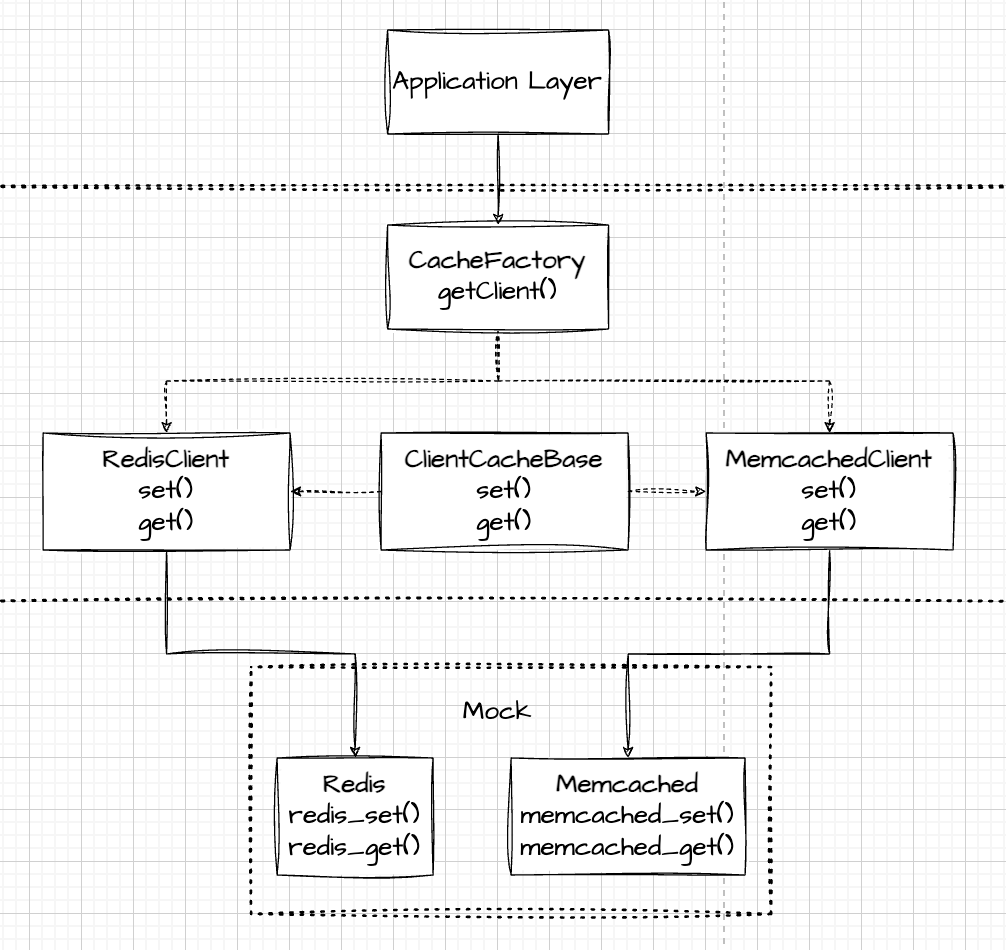

Try running this code to see how it works.

In [5]:
cache_provider = CacheFactory()
redis: ClientCacheBase = cache_provider.getClient('REDIS')
redis.set("username", "john_doe")
username = redis.get("username")
print(username)

john_doe


In the application code layer, it has no knowledge of how this Client is created; it has to go through the Factory to choose the Client class it needs. It interacts directly with the set and get methods without needing to know anything about the specific Client classes like RedisClient and MemcachedClient.

The reason for hiding these Client classes and the logic for creating them is for encapsulation and other benefits such as reusability and modularity. In a large project with many team members collaborating, the more you can compartmentalize and reduce dependencies, the better. In the application layer, they don't need to know how the Client is created; they can focus on their specific functionality and write logic related to their features. Another team member can handle the task of creating a new Client, which is unrelated to the application layer. When you separate these parts, encapsulation becomes high, leading to the potential for reuse in other places or other projects.

### Optimization
In the getClient() function, you should not use a string as an input because if you don't constrain the input and only accept a string, there's a risk of receiving an unexpected string that doesn't correspond to the desired Client class. Instead, you should use an Enum. Please update the code as shown below.

In [6]:
from enum import Enum

class CacheType(Enum):
    REDIS = 0
    MEMCACHED = 1

class CacheFactory():
    def getClient(self, cache_type: CacheType):
        if (cache_type == CacheType.REDIS):
            return RedisClient(host='localhost', port=6379, db=0)
        elif (cache_type == CacheType.MEMCACHED):
            return MemcachedClient(host='localhost', port=11211)

The application code will be updated as follows.

In [7]:
cache_provider = CacheFactory()
redis = cache_provider.getClient(CacheType.REDIS)
memcached = cache_provider.getClient(CacheType.MEMCACHED)
redis.set("username", "john_doe")
username = redis.get("username")
print(username)
memcached.set("username", "john_doe2")
username = memcached.get("username")
print(username)

john_doe
john_doe2


### Abtract Factory Pattern
Through the steps in the example above, I hope you have somewhat grasped the essence of the Factory pattern and its effectiveness. Going a step further, let's delve into the Abstract Factory pattern. Imagine the requirement has changed, and we need to design a Cache Client for both Linux and Windows. However, the Redis and Memcached libraries do not have a common version for both Linux and Windows. They only have separate libraries for each environment. Let's assume they are named RedisWindows, MemcachedWindows, RedisLinux, and MemcachedLinux, and these libraries are also encapsulated inside mocks.

The reason for choosing the Abstract Factory pattern is that, in addition to the characteristics that the Factory provides, as I introduced earlier, with the Factory, you only see horizontal similarities.

| Redis      | Memcached |
| :---------: | :-----:|
| x | x |

With the Abstract Factory, it's cross-functional; when you encounter this identification feature, you must choose the Abstract Factory instead of the Factory because the Factory cannot handle it as comprehensively as the Abstract Factory.

|   | Redis  | Memcached |
|:-----|:-----:|:-----:|
| Windows      | x | x |
| Linux      | x | x |


To make it easier to visualize, I've updated the block diagram for the Abstract Factory as shown below.

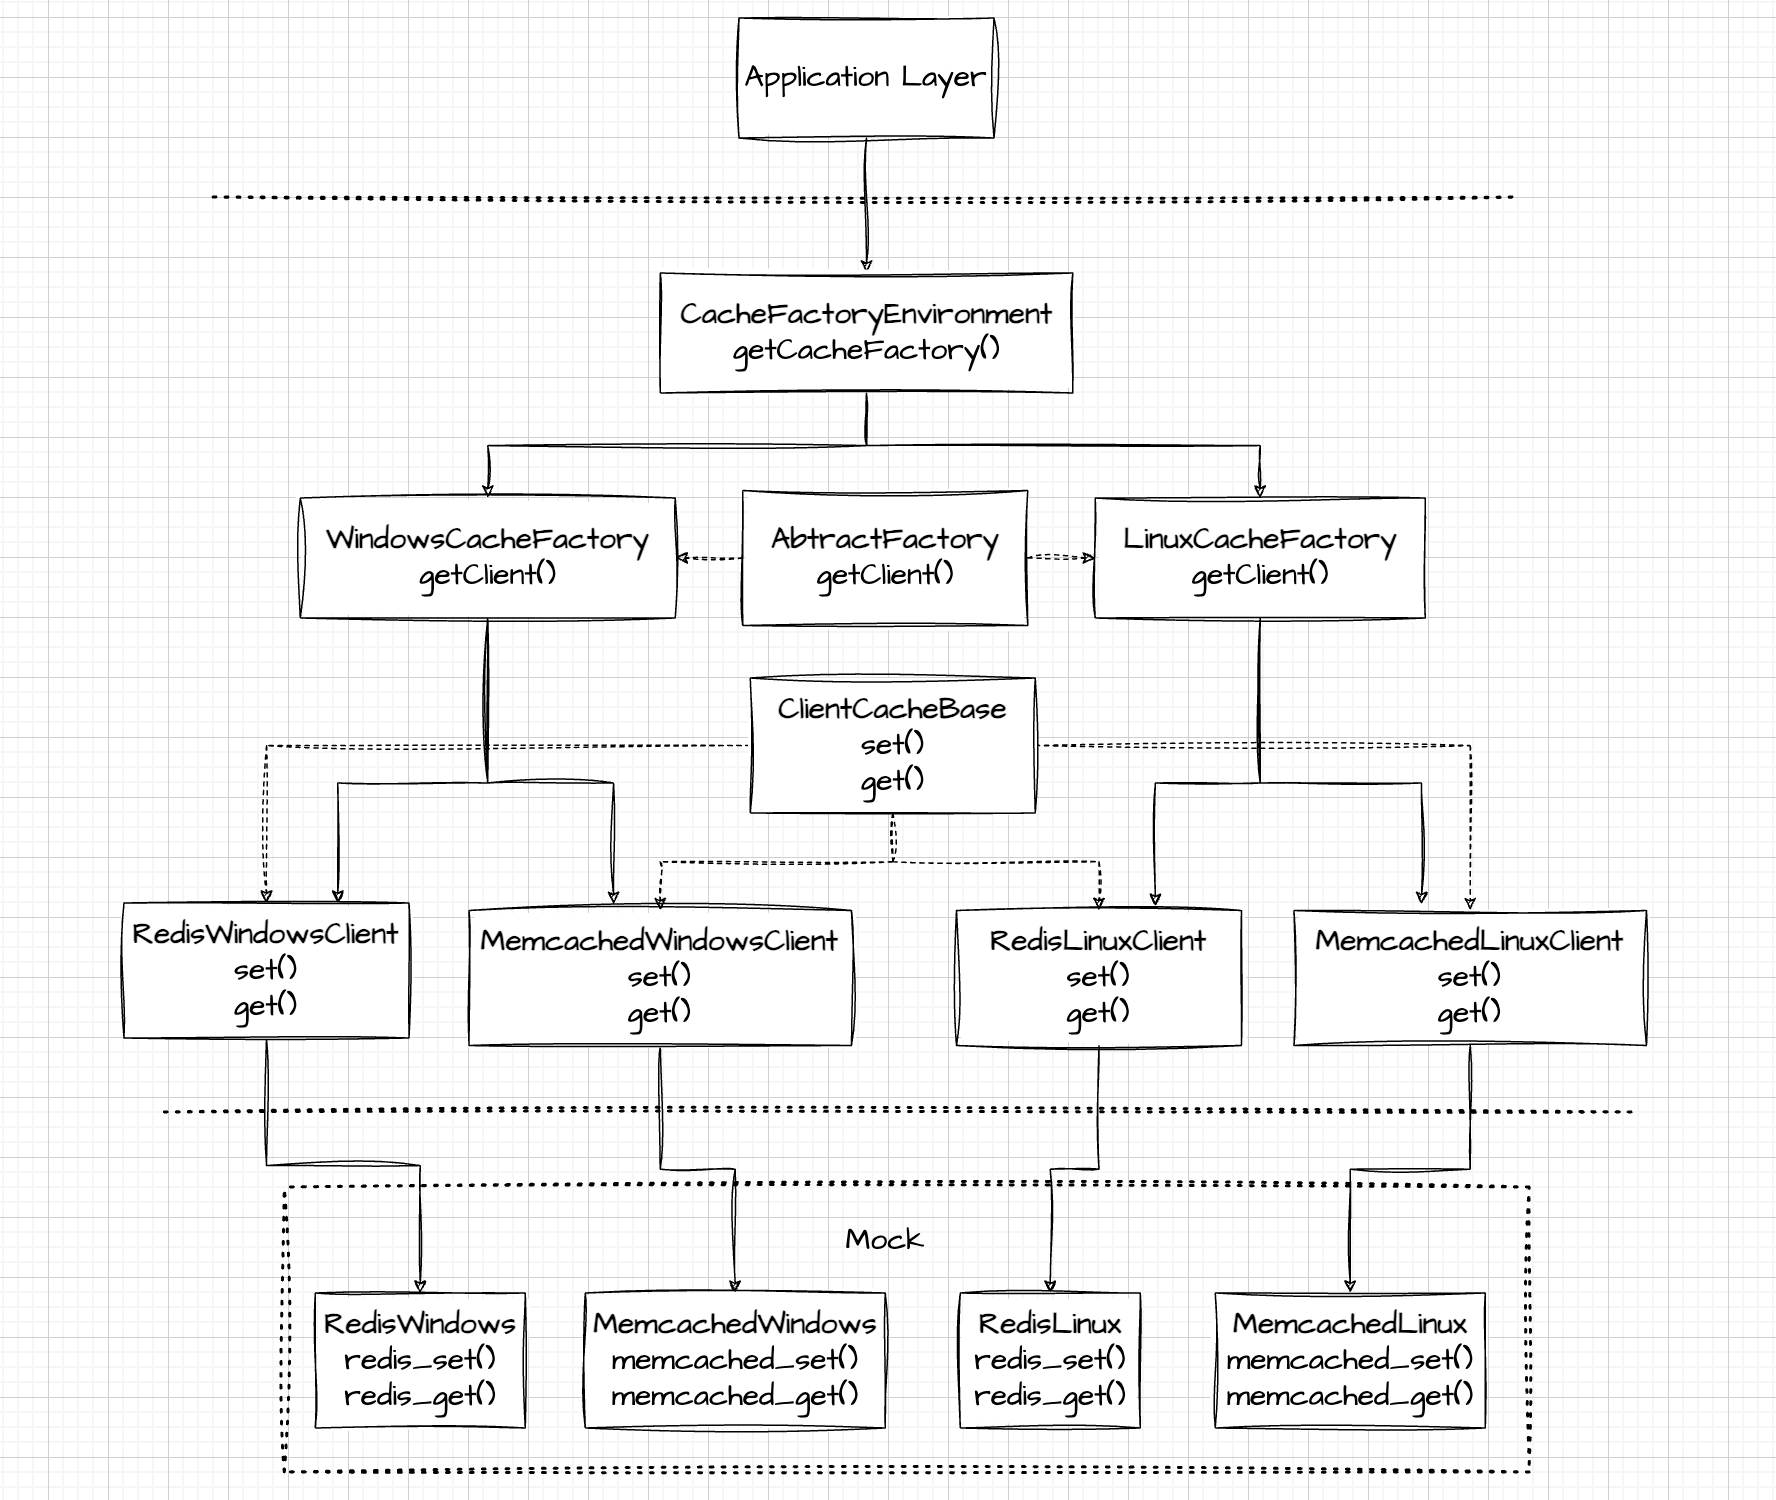

Based on the block diagram above, we need to update the Client classes for Redis and Memcached in both Windows and Linux environments to align with the design of the Abstract Factory pattern.

In [8]:
from moke import RedisWindows, MemcachedWindows, RedisLinux, MemcachedLinux

class RedisWindowsClient(ClientCacheBase):
    def __init__(self, port, host, db):
        self.redis = RedisWindows(port, host, db)

    def set(self, key, value):
        self.redis.redis_set(key, value)

    def get(self, key):
        return self.redis.redis_get(key)


class MemcachedWindowsClient(ClientCacheBase):
    def __init__(self, port, host):
        self.memcached = MemcachedWindows(port, host)

    def set(self, key, value):
        self.memcached.memcached_set(key, value)

    def get(self, key):
        return self.memcached.memcached_get(key)


class RedisLinuxClient(ClientCacheBase):
    def __init__(self, port, host, db):
        self.redis = RedisLinux(port, host, db)

    def set(self, key, value):
        self.redis.redis_set(key, value)

    def get(self, key):
        return self.redis.redis_get(key)


class MemcachedLinuxClient(ClientCacheBase):
    def __init__(self, port, host):
        self.memcached = MemcachedLinux(port, host)

    def set(self, key, value):
        self.memcached.memcached_set(key, value)

    def get(self, key):
        return self.memcached.memcached_get(key)

The next step is to group the Factory classes together

In [9]:
class AbstractFactory(ABC):
    """Interface for Abstract Factory."""

    @abstractmethod
    def getClient(self, cache_type: CacheType):
        """getClient method"""


class WindowsCacheFactory(AbstractFactory):
    def getClient(self, cache_type: CacheType):
        if cache_type == CacheType.REDIS:
            return RedisWindowsClient(host="localhost", port=6379, db=0)
        elif cache_type == CacheType.MEMCACHED:
            return MemcachedWindowsClient(host="localhost", port=11211)


class LinuxCacheFactory(AbstractFactory):
    def getClient(self, cache_type: CacheType):
        if cache_type == CacheType.REDIS:
            return RedisLinuxClient(host="localhost", port=6379, db=0)
        elif cache_type == CacheType.MEMCACHED:
            return MemcachedLinuxClient(host="localhost", port=11211)

The essence of the Abstract Factory is similar to the Factory, but it adds an additional layer of Abstract Factory compared to the previous Factory example, to group the similarities. Previously, you would see the getClient() function used to retrieve a Client object without concerning yourself with the logic of creating this Client. Similarly, at the Abstract Factory level, you also need a similar function getCacheFactory(), which is just one level higher but essentially the same.

In [10]:
class CacheFactoryEnvironment:
    def getCacheFactory(self, is_windows: bool):
        if is_windows:
            return WindowsCacheFactory()
        else:
            return LinuxCacheFactory()

Please update the code in the application layer as follows

In [11]:
# Assuming that the environment is Windows
is_windows = True

cache_environment = CacheFactoryEnvironment()
cache_provider: AbstractFactory = cache_environment.getCacheFactory(is_windows)

redis = cache_provider.getClient(CacheType.REDIS)
memcached = cache_provider.getClient(CacheType.MEMCACHED)

redis.set("username", "john_doe")
username = redis.get("username")
print(username)
memcached.set("username", "john_doe2")
username = memcached.get("username")
print(username)

john_doe
john_doe2


### In conclusion
Through the example above, by designing patterns and coordinating them seamlessly, your application code will interact with the corresponding library code while ensuring code integrity. This makes maintenance easier, improves teamwork skills, and enhances the ability to encapsulate objects for convenient reuse. Especially with the Factory pattern and Abstract Factory pattern, you can conceal the creation logic at the Client layer.